In [38]:
import os
import re
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist, cosine, jensenshannon
import seaborn as sns
from bert_serving.client import BertClient
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import artm
from nltk.corpus import stopwords 
from pymystem3 import Mystem
from tqdm.auto import tqdm
import pickle
import gc
from scripts import readability as rb
import itertools
from sklearn.feature_extraction.text import CountVectorizer



In [218]:
russian_stopwords = set(stopwords.words("russian"))
m = Mystem()
m._mystemargs = ['--format', 'json', '-gidwc']


In [2]:
save_folder = 'test_final1'

In [3]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [4]:
def text_to_chunks(text, words_in_chunk=1024, min_chunk_size=500):
    tokens = text.split(' ')
    n_chunks = len(tokens) // words_in_chunk
    return list(' '.join(ch) for ch in chunks(tokens, words_in_chunk) 
                if len(ch) > min_chunk_size)

In [5]:
def chunk_to_sentences(text_chunk, max_sentence_size=128):
    return list(' '.join(ch) for ch in chunks(text_chunk.split(), max_sentence_size))

In [6]:
def text_to_sentences(text):
    return [s for chunk in text_to_chunks(text) for s in chunk_to_sentences(chunk)]

In [7]:
def process_texts(texts):
    data = []
    for i, text in enumerate(texts):
        for j, chunk in enumerate(text_to_chunks(text)):
            for sent in chunk_to_sentences(chunk):
                data.append((i, j, sent))
    return pd.DataFrame(data, columns=['book', 'chunk', 'sentence'])

In [8]:
def normalize_text(text):
    text = unicodedata.normalize("NFKC", text).strip()
    text = text.replace('?..', '?')
    text = text.replace('!..', '!')
    text = text.replace('...', '…')
    text = text.replace('--', '–')
    text = re.sub('[…]+', ' … ', text)
    text = re.sub('[_]+', '_', text)
    text = re.sub('[\n]+', ' \n ', text)
    text = re.sub('[*]+', '*', text)
    return text

In [9]:
bc = BertClient()

In [13]:
polka_texts = []
for f in sorted(os.listdir('../pb-stylistic/txt_cut/')):
    with open('../pb-stylistic/txt_cut/' + f) as fi:
        polka_texts.append(normalize_text(fi.read()))

In [10]:
polka_data = process_texts(polka_texts)

In [12]:
%%time
polka_data['bert'] = list(bc.encode(polka_data['sentence'].tolist()))

CPU times: user 1.42 s, sys: 452 ms, total: 1.88 s
Wall time: 2h 2min 13s


In [14]:
ridero_texts = []
for f in sorted(os.listdir('ridero_books'))[:]:
    with open('ridero_books/' + f) as fi:
        ridero_texts.append(normalize_text(fi.read()))

In [12]:
ridero_data = process_texts(ridero_texts)

In [15]:
%%time
ridero_data['bert'] = list(bc.encode(ridero_data['sentence'].tolist()))

CPU times: user 2.53 s, sys: 711 ms, total: 3.24 s
Wall time: 3h 13min 23s


In [16]:
with open(f'{save_folder}/ridero_data.pkl', 'wb') as f:
    pickle.dump(ridero_data, f)
with open(f'{save_folder}/polka_data.pkl', 'wb') as f:
    pickle.dump(polka_data, f)

In [11]:
with open(f'{save_folder}/ridero_data.pkl', 'rb') as f:
    ridero_data = pickle.load(f)
with open(f'{save_folder}/polka_data.pkl', 'rb') as f:
    polka_data = pickle.load(f)

In [153]:
ridero_chunks = ridero_data.groupby(['book', 'chunk'])['bert'].apply(lambda x: x.mean(axis=0)).reset_index()
polka_chunks = polka_data.groupby(['book', 'chunk'])['bert'].apply(lambda x: x.mean(axis=0)).reset_index()

In [19]:
%%time
cdb = cdist(
    np.stack(ridero_chunks['bert'].values), 
    np.stack(polka_chunks['bert'].values),
    metric=cosine)

CPU times: user 31min 57s, sys: 3.2 s, total: 32min
Wall time: 31min 57s


In [20]:
with open(f'{save_folder}/bert_dists_cosine', 'wb') as f:
    pickle.dump(cdb, f)

In [120]:
with open(f'{save_folder}/bert_dists_cosine', 'rb') as f:
    cdb = pickle.load(f)

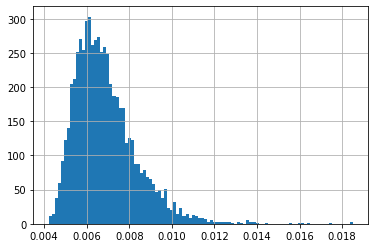

In [21]:
pd.Series(np.median(cdb, axis=0)).hist(bins=100)

In [22]:
dd = np.vstack([
    np.stack(ridero_chunks['bert'].values), 
    np.stack(polka_chunks['bert'].values)
])
h = [0] * len(ridero_chunks) + [1] * len(polka_chunks)

5


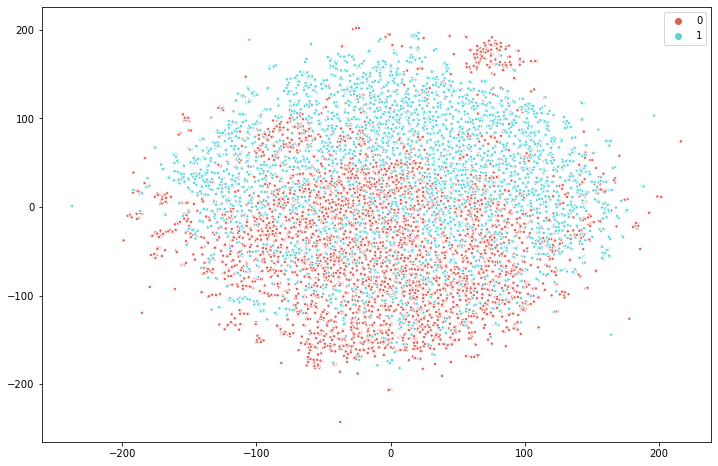

20


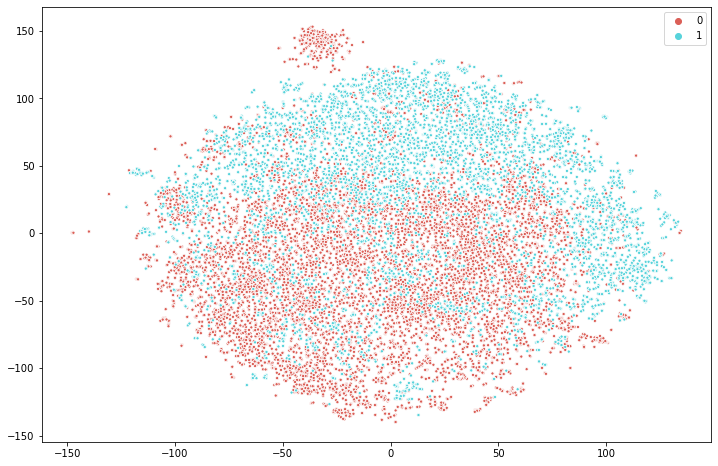

50


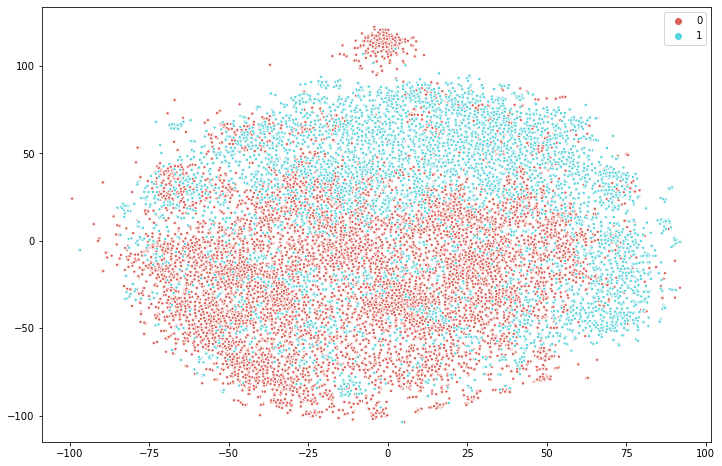

100


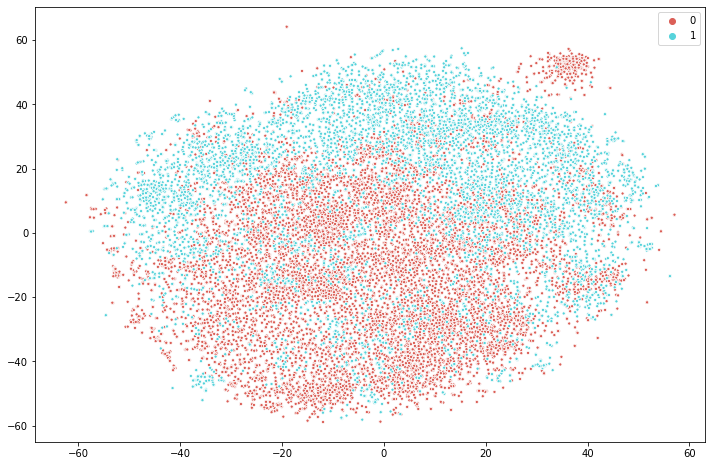

CPU times: user 1h 6min 48s, sys: 22.1 s, total: 1h 7min 10s
Wall time: 1h 7min 8s


In [23]:
%%time
perplexity = [5, 20, 50, 100]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33)
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

In [123]:
pairs = np.unravel_index(cdb.ravel().argpartition(10)[:10], cdb.shape)
cdb[pairs]

array([0.00124941, 0.00124218, 0.00127546, 0.00126745, 0.00116432,
       0.00126773, 0.00127946, 0.00130448, 0.00129774, 0.00130974])

In [125]:
for r, p in zip(pairs[0], pairs[1]):
    d = cdb[r, p]
    dir_name = f'{save_folder}/bert pairs (x100)/{round(d*100, 5)}'
    os.mkdir(dir_name)
    with open (dir_name + f'/ridero_{r}.txt', 'w') as f:
        f.write(ridero_chunks.iloc[r])
    with open (dir_name + f'/polka_{p}.txt', 'w') as f:
        f.write(polka_chunks.iloc[p])

In [24]:
def topic_model_processor(text):
    return mystem_processor(text)

In [25]:
def mystem_processor(text):
    parsed = m.analyze(text)
    tokens = []
    for w in parsed:
        try:
            anal = w['analysis'][0]
            gr = anal['gr']
            lex = anal['lex']
            if 'имя,' in gr or 'фам,' in gr or 'отч,' in gr:
                raise
            if lex in russian_stopwords:
                raise
            if not gr.startswith(('S,', 'S=')):
                raise
            if len(lex) < 3:
                raise
            tokens.append(lex)
        except:
            continue
    return ' '.join(tokens)

In [26]:
def process_chunks_from_dataframe(df, processor=None):
    return df.groupby(['book', 'chunk'])['sentence'] \
            .apply(lambda x: processor(' '.join(x)))

In [27]:
%%time
polka_chunks_processed = process_chunks_from_dataframe(polka_data, topic_model_processor)
ridero_chunks_processed = process_chunks_from_dataframe(ridero_data, topic_model_processor)

CPU times: user 44.1 s, sys: 1.3 s, total: 45.4 s
Wall time: 8min 16s


In [35]:
model = artm.load_artm_model(f'S_maxdf6_100_400_prolly_best')
model.reshape_topics([f'topic_{i}' for i in range(100, 500)])

In [29]:
key = lambda x: [int(s) for s in x.split('_')]

In [30]:
# POLKA
for ind, text in zip(polka_chunks_processed.index, polka_chunks_processed.values):
    name = '_'.join([*map(str, ind) ])
    with open(f'{save_folder}/processed_chunks_for_tm_polka/' + name, 'w') as f:
        f.write(text)

# RIDERO
for ind, text in zip(ridero_chunks_processed.index, ridero_chunks_processed.values):
    name = '_'.join([*map(str, ind) ])
    with open(f'{save_folder}/processed_chunks_for_tm_ridero/' + name, 'w') as f:
        f.write(text)

In [31]:
# POLKA
with open(f'{save_folder}/artm data/wv_polka.txt', 'w') as f1:
    folder = f'{save_folder}/processed_chunks_for_tm_polka'
    for name in sorted(os.listdir(folder), key=key):
        with open(folder + '/' + name) as doc:
            tokens = doc.read().replace('?', '').replace('\n', ' ').split()
            doc_voc = Counter(tokens)
            s = ' '.join(f'{w}:{c}' for w, c in sorted(doc_voc.items()))
            row = f'{name} {s}\n'
            f1.write(row)

# RIDERO
with open(f'{save_folder}/artm data/wv_ridero.txt', 'w') as f1:
    folder = f'{save_folder}/processed_chunks_for_tm_ridero'
    for name in sorted(os.listdir(folder), key=key):
        with open(folder + '/' + name) as doc:
            tokens = doc.read().replace('?', '').replace('\n', ' ').split()
            doc_voc = Counter(tokens)
            s = ' '.join(f'{w}:{c}' for w, c in sorted(doc_voc.items()))
            row = f'{name} {s}\n'
            f1.write(row)

In [32]:
# POLKA
polka_batch_vectorizer = artm.BatchVectorizer(
    data_path=f'{save_folder}/artm data/wv_polka.txt',
    data_format='vowpal_wabbit',
    target_folder=f'{save_folder}/artm data/polka batches')

# RIDERO
ridero_batch_vectorizer = artm.BatchVectorizer(
    data_path=f'{save_folder}/artm data/wv_ridero.txt',
    data_format='vowpal_wabbit',
    target_folder=f'{save_folder}/artm data/ridero batches')

In [33]:
ridero_topics = model.transform(ridero_batch_vectorizer).T.sort_index()
ridero_topics.index = ridero_chunks_processed.index

In [34]:
polka_topics = model.transform(polka_batch_vectorizer).T.sort_index()
polka_topics.index = polka_chunks_processed.index

In [35]:
ridero_topics.to_csv(f'{save_folder}/ridero_topics.csv')
polka_topics.to_csv(f'{save_folder}/polka_topics.csv')

In [72]:
ridero_topics = pd.read_csv(f'{save_folder}/ridero_topics.csv').set_index(['book', 'chunk'])
polka_topics = pd.read_csv(f'{save_folder}/polka_topics.csv').set_index(['book', 'chunk'])

In [36]:
%%time
cd = cdist(ridero_topics, polka_topics, metric=jensenshannon)

CPU times: user 39min 40s, sys: 1min, total: 40min 41s
Wall time: 37min 17s


In [37]:
with open(f'{save_folder}/topic_dists', 'wb') as f:
    pickle.dump(cd, f)

In [3]:
with open(f'{save_folder}/topic_dists', 'rb') as f:
    cd = pickle.load(f)

In [5]:
pairs = np.unravel_index(cd.ravel().argpartition(10)[:10], cd.shape)
cd[pairs]

array([0.47622267, 0.47980835, 0.47370363, 0.47847513, 0.48236952,
       0.42374981, 0.46874722, 0.48452957, 0.48642544, 0.48507513])

In [39]:
pairs = np.unravel_index(cd.ravel().argpartition(10)[:10], cd.shape)
sorted(cd[pairs])

[0.42374981351128366,
 0.46874721994215773,
 0.4737036273091806,
 0.4762226717356674,
 0.4784751254650265,
 0.4798083459802289,
 0.48236951739450157,
 0.4845295653786464,
 0.48507512808695685,
 0.48642543885673356]

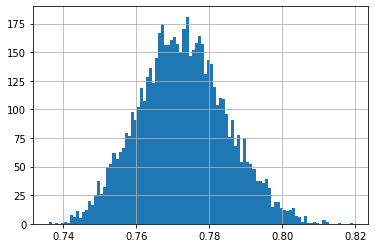

In [42]:
pd.Series(np.median(cd, axis=0)).hist(bins=100)

In [15]:
dd = np.vstack([ridero_topics.values, polka_topics.values])
h = [0] * len(ridero_topics) + [1] * len(polka_topics)

5


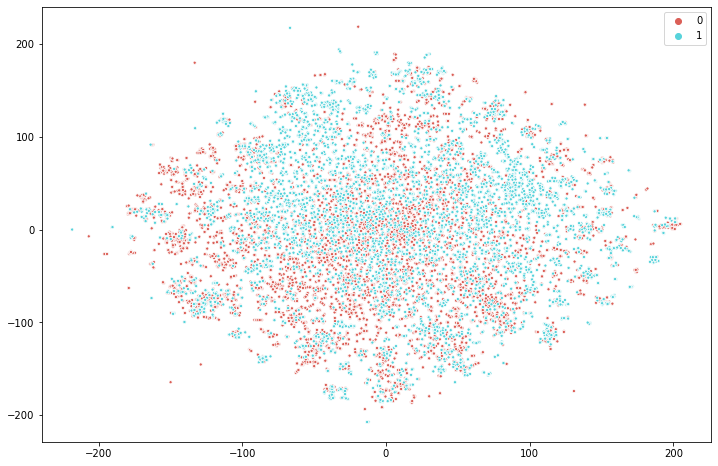

20


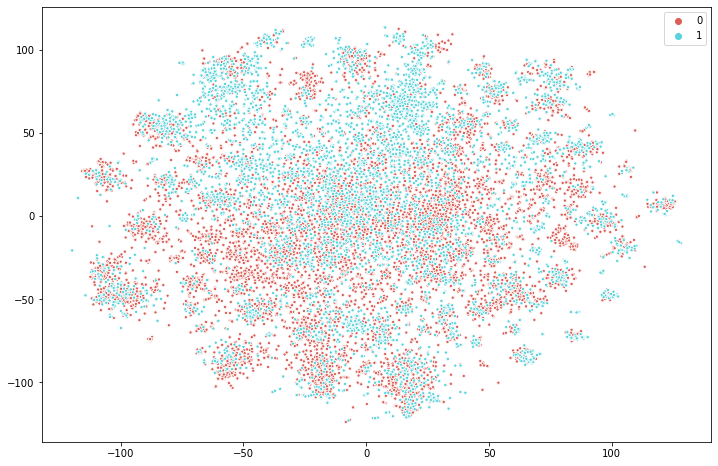

50


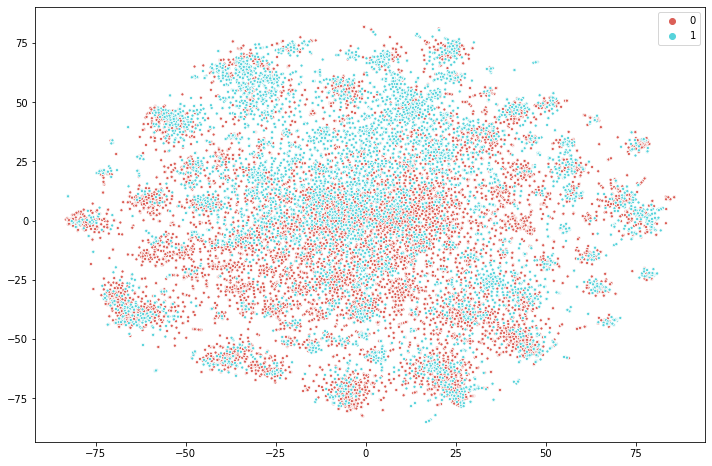

100


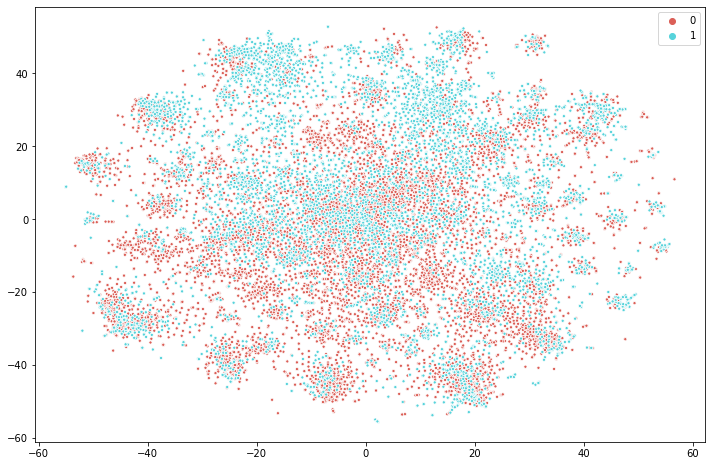

CPU times: user 59min 34s, sys: 1min 59s, total: 1h 1min 34s
Wall time: 56min 40s


In [41]:
%%time
perplexity = [5, 20, 50, 100]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33)
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

In [ ]:
%%time
perplexity = [20, 50]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33,
               metric=jensenshannon)
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

In [25]:
pairs

(array([6072, 6073, 6072, 5745, 6072, 6072, 3431, 4522, 6396, 7145]),
 array([6040, 3762, 6035, 2256, 4774, 6041, 5105, 4724, 3762, 1740]))

In [211]:
ridero_chunks = ridero_data.groupby(['book', 'chunk'])['sentence'].apply(lambda x: ' '.join(x))
polka_chunks = polka_data.groupby(['book', 'chunk'])['sentence'].apply(lambda x: ' '.join(x))

In [34]:
for r, p in zip(pairs[0], pairs[1]):
    d = cd[r, p]
    dir_name = f'{save_folder}/topic pairs/{round(d, 5)}'
    os.mkdir(dir_name)
    with open (dir_name + f'/ridero_{r}.txt', 'w') as f:
        f.write(ridero_chunks.iloc[r])
    with open (dir_name + f'/polka_{p}.txt', 'w') as f:
        f.write(polka_chunks.iloc[p])

NameError: name 'cd' is not defined

In [129]:
cd[9046, 4917]

0.7085203052483521

In [131]:
model_tokens = model.score_tracker['TopTokensScore10'].last_tokens
for t in ridero_topics.iloc[9046].sort_values()[-3:].index:
    print(model_tokens[t])

['тарелка', 'столовая', 'суп', 'кухня', 'повар', 'вилка', 'салат', 'кастрюля', 'котлета', 'яичница']
['столик', 'ресторан', 'кафе', 'мадам', 'официант', 'официантка', 'месье', 'мадемуазель', 'мсье', 'меню']
['доктор', 'врач', 'больной', 'пациент', 'клиника', 'лечение', 'хирург', 'софия', 'медицина', 'психиатр']


In [130]:
model_tokens = model.score_tracker['TopTokensScore10'].last_tokens
for t in polka_topics.iloc[4917].sort_values()[-3:].index:
    print(model_tokens[t])

['квартира', 'подъезд', 'соседка', 'прихожая', 'жилец', 'ванная', 'холодильник', 'кухня', 'квартирка', 'коммуналка']
['поезд', 'вагон', 'билет', 'вокзал', 'станция', 'купе', 'рельс', 'платформа', 'электричка', 'перрон']
['доктор', 'врач', 'больной', 'пациент', 'клиника', 'лечение', 'хирург', 'софия', 'медицина', 'психиатр']


In [114]:
polka_data.groupby(['book', 'chunk'])['book'].apply(lambda x: np.mean(x)).iloc[2256]

230.0

In [115]:
polka_texts[230]

'О СОБЕСЕДНИКЕ   \n  Скажите, что в безумце производит на вас наиболее грозное впечатление безумия? Расширенные зрачки - потому что они невидящие, ни на что в частности не устремленные, пустые. Безумные речи, потому что, обращаясь к вам, безумный не считается с вами, с вашим существованием, как бы не желает его признавать, абсолютно не интересуется вами. Мы боимся в сумасшедшем главным образом того жуткого абсолютного безразличия, которое он выказыва-ет нам. Нет ничего более страшного для человека, чем другой человек, которому нет до него никакого дела. Глубокий смысл имеет культурное притворство, вежливость, с помощью которой мы ежеминутно подчеркиваем интерес друг к другу.   \n  Обыкновенно человек, когда имеет что-нибудь сказать, идет к людям, ищет слушателей; - поэт же наоборот,- бежит "на берега пустынных волн, в широкошумные дубровы". Ненормаль-ность очевидна  …   Подозрение в безумии падает на поэта. И люди правы, когда клеймят именем безумца того, чьи речи обращены к бездушным 

In [22]:
from scripts import readability as rb
def readability_processor(text):
    text = m.analyze(text)
    pos_tags = rb.pos_tagger(text)
    pos_input = ' '.join(pos_tags)
    return np.array([
        *rb.pos_fraction(pos_tags),
        rb.type_token_ratio(text),
        rb.avg_sent_len(pos_input),
        rb.dialog_fraction(pos_input)
    ])

In [23]:
def get_texts_readability(texts):
    data = []
    for i, text in enumerate(texts):
        for j, chunk in enumerate(text_to_chunks(text)):
            data.append((i, j, readability_processor(chunk)))
    return pd.DataFrame(data, columns=['book', 'chunk', 'readability'])

In [24]:
%%time
polka_readability = get_texts_readability(polka_texts)
ridero_readability = get_texts_readability(ridero_texts)

else {'analysis': [], 'text': '¦'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': []

else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': []

else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': []

else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': []

else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⁄'}
CPU times: user 3min 20s, sys: 9.68 s, total: 3min 29s
Wall time: 17min 13s


In [25]:
with open(f'{save_folder}/ridero_read.pkl', 'wb') as f:
    pickle.dump(ridero_readability, f)
with open(f'{save_folder}/polka_read.pkl', 'wb') as f:
    pickle.dump(polka_readability, f)

In [163]:
with open(f'{save_folder}/ridero_read.pkl', 'rb') as f:
    ridero_readability = pickle.load(f)
with open(f'{save_folder}/polka_read.pkl', 'rb') as f:
    polka_readability = pickle.load(f)

In [164]:
polka_readability.shape

(6063, 3)

In [28]:
%%time
cdr = cdist(np.stack(ridero_readability['readability'].values),
            np.stack(polka_readability['readability'].values), 
            metric=cosine)

CPU times: user 30min 32s, sys: 12.4 s, total: 30min 45s
Wall time: 30min 46s


In [29]:
with open(f'{save_folder}/readability_dists_cosine', 'wb') as f:
    pickle.dump(cdr, f)

In [30]:
with open(f'{save_folder}/readability_dists_cosine', 'rb') as f:
    cdr = pickle.load(f)

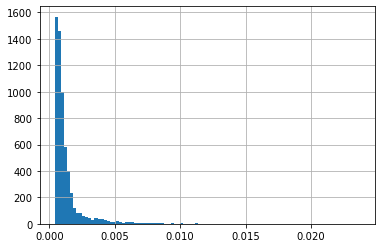

In [31]:
pd.Series(np.median(cdr, axis=0)).hist(bins=100)

In [36]:
pairs = np.unravel_index(cdr.ravel().argpartition(10)[:10], cdr.shape)
sorted(cdr[pairs])

[6.465640310926446e-07,
 6.474927090049931e-07,
 7.149926083416247e-07,
 7.25293868741872e-07,
 7.739603745671175e-07,
 8.240768227807393e-07,
 8.270241053098815e-07,
 8.2821237856745e-07,
 8.581245375394175e-07,
 8.848679934336801e-07]

In [52]:
dd = np.vstack([
    np.stack(ridero_readability['readability'].values), 
    np.stack(polka_readability['readability'].values)
])
h = [0] * len(ridero_readability) + [1] * len(polka_readability)

5


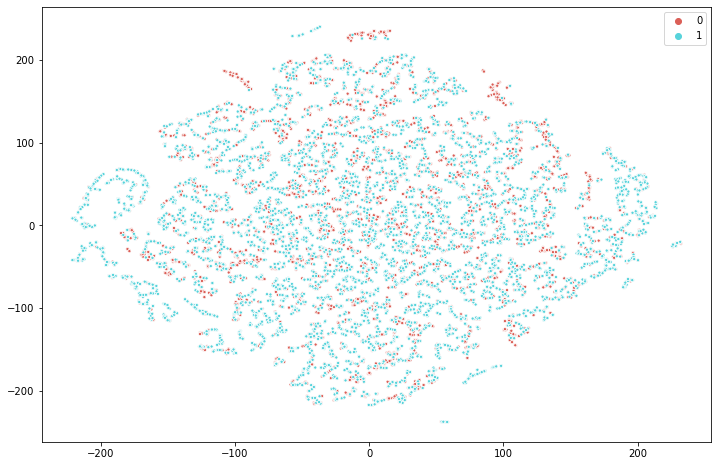

20


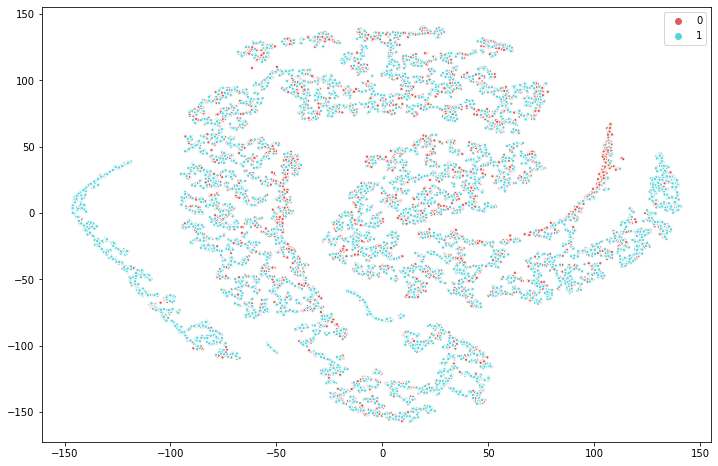

50


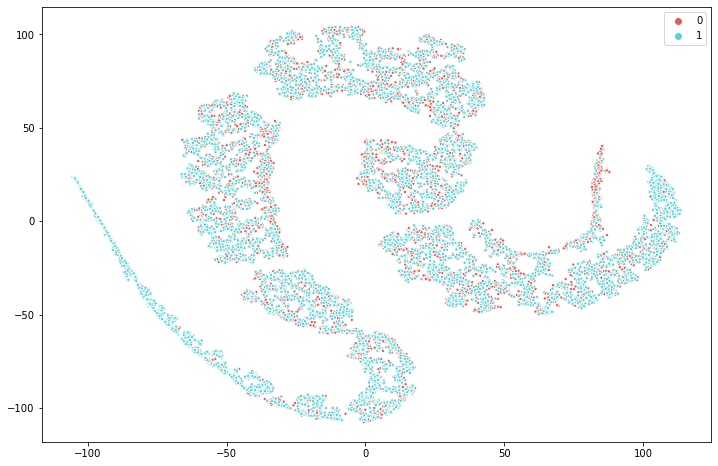

100


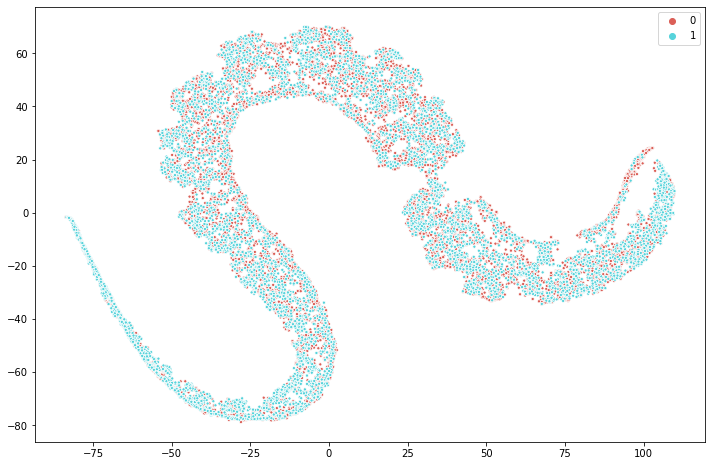

CPU times: user 46min 52s, sys: 1min 52s, total: 48min 44s
Wall time: 44min 21s


In [53]:
%%time
perplexity = [5, 20, 50, 100]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33)
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

20


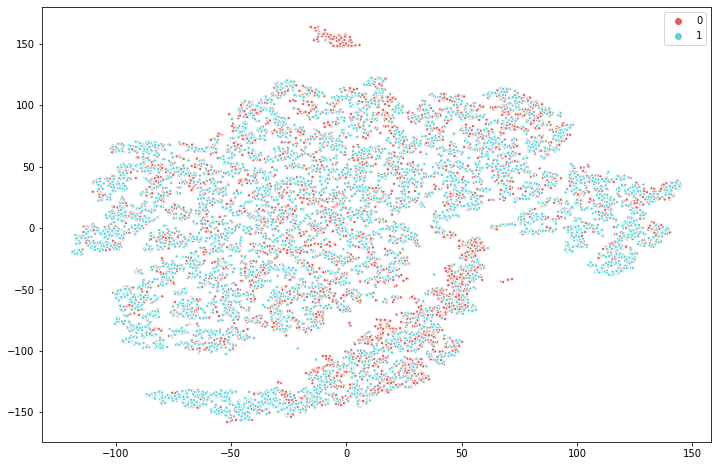

50


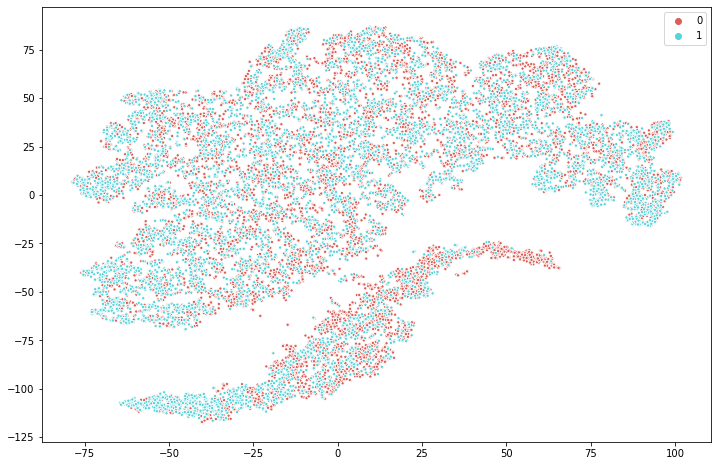

CPU times: user 1h 34min 53s, sys: 3min 15s, total: 1h 38min 8s
Wall time: 1h 29min 1s


In [61]:
%%time
perplexity = [20, 50]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33, 
                metric=cosine)
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

In [38]:
for r, p in zip(pairs[0], pairs[1]):
    d = cdr[r, p]
    dir_name = f'{save_folder}/read pairs (x1e7)/{round(d*10**7, 5)}'
    os.mkdir(dir_name)
    with open (dir_name + f'/ridero_{r}.txt', 'w') as f:
        f.write(ridero_chunks.iloc[r])
    with open (dir_name + f'/polka_{p}.txt', 'w') as f:
        f.write(polka_chunks.iloc[p])

In [39]:
pairs[0], pairs[1]

(array([8824, 8824, 7819, 5613, 4349, 6293,  183, 4391, 6576, 8824]),
 array([1801, 5597, 1960,  163, 4254,   47, 3160, 3160, 4564, 5800]))

In [59]:
euclidean(polka_readability['readability'].iloc[47], ridero_readability['readability'].iloc[6293])

0.28015918256002376

In [55]:
with open('stop3grams.txt', 'r') as f:
    stop3grams = set([s.lower() for s in f.read().splitlines()])

In [62]:
all_triplets = [
    t for t 
    in [' '.join(x).lower() for x in itertools.combinations_with_replacement(rb.ALL_POS, 3)]
    if t not in stop3grams
]

In [63]:
cv = CountVectorizer(vocabulary=all_triplets, ngram_range=(3, 3))

In [177]:
def processor_3pos(text):
    return cv.transform(
        [' '.join(rb.pos_tagger(m.analyze(text)))]
    ).toarray()[0]

In [178]:
def get_texts_3pos(texts):
    data = []
    for i, text in enumerate(texts):
        for j, chunk in enumerate(text_to_chunks(text)):
            data.append((i, j, processor_3pos(chunk)))
    return pd.DataFrame(data, columns=['book', 'chunk', '3pos'])

In [182]:
%%time
polka_pos_3grams = get_texts_3pos(polka_texts)

else {'analysis': [], 'text': '¦'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': []

In [183]:
ridero_pos_3grams = get_texts_3pos(ridero_texts)

else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '☺'}
else {'analysis': [], 'text': '☺'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⁄'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '©'}
else {'analysis': []

else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': []

else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': []

else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': []

else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⁄'}


In [184]:
assert polka_pos_3grams.shape == polka_chunks.shape

In [185]:
%%time
cd3pos = cdist(
    np.stack(ridero_pos_3grams['3pos'].values),
    np.stack(polka_pos_3grams['3pos'].values),
    metric=cosine)

CPU times: user 48min 12s, sys: 42.8 s, total: 48min 55s
Wall time: 49min 1s


In [186]:
with open(f'{save_folder}/3pos_dists_cosine', 'wb') as f:
    pickle.dump(cd3pos, f)

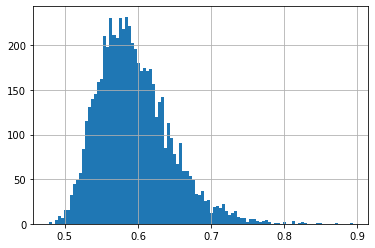

In [187]:
pd.Series(np.median(cd3pos, axis=0)).hist(bins=100)

In [188]:
pairs = np.unravel_index(cd3pos.ravel().argpartition(10)[:10], cd3pos.shape)
sorted(cd3pos[pairs])

[0.026864087054476293,
 0.028844487325829338,
 0.03572878535216728,
 0.037158983825742564,
 0.04356674086104362,
 0.05544779612222861,
 0.05683106812070238,
 0.06659616827142611,
 0.06835232722346052,
 0.07191695805834175]

In [189]:
dd = np.vstack([
    np.stack(ridero_pos_3grams['3pos'].values),
    np.stack(polka_pos_3grams['3pos'].values),
])
h = [0] * len(ridero_pos_3grams) + [1] * len(polka_pos_3grams)

5


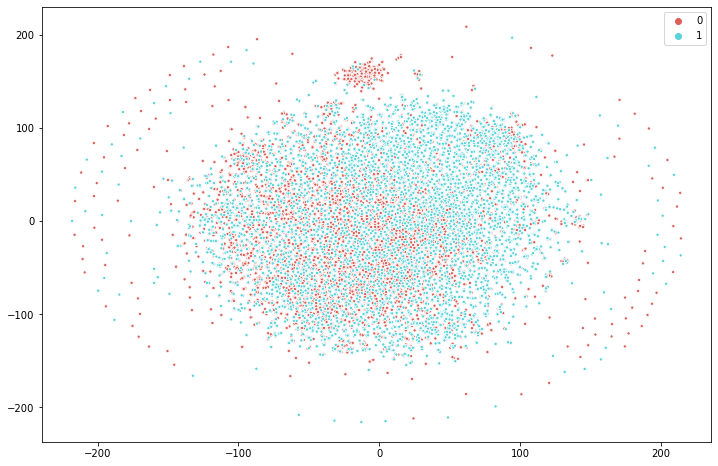

20


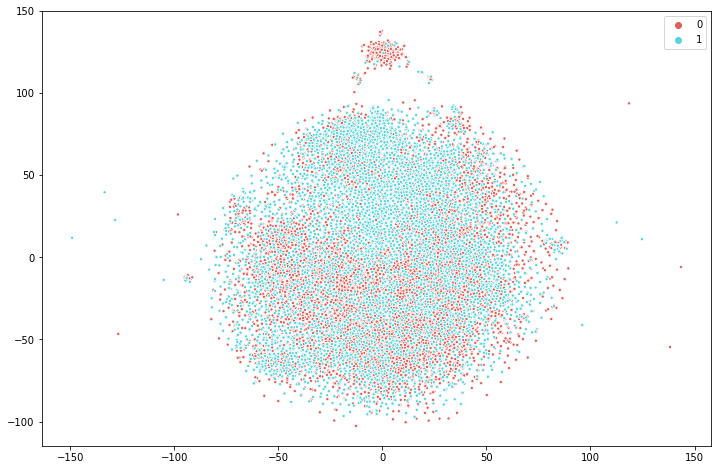

50


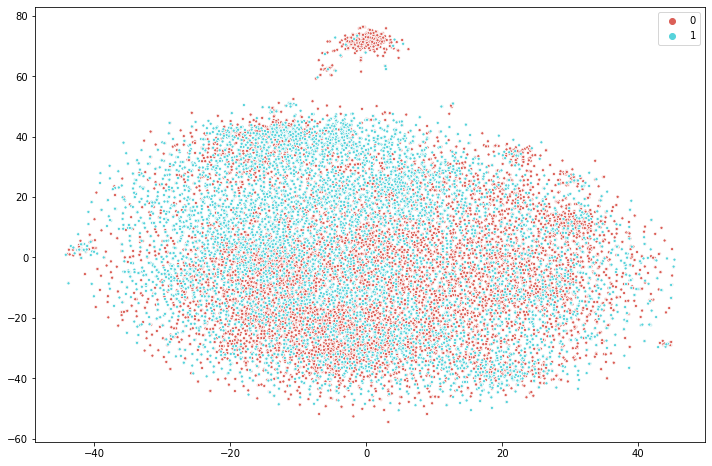

100


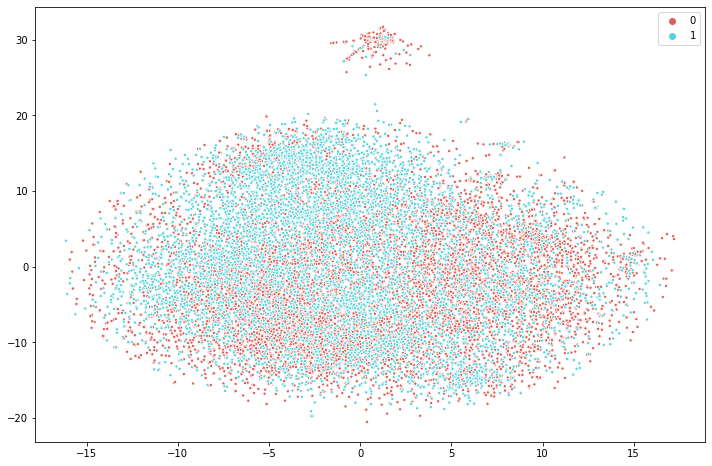

CPU times: user 1h 23min 21s, sys: 6min, total: 1h 29min 22s
Wall time: 1h 24min 34s


In [216]:
%%time
perplexity = [5, 20, 50, 100]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33, 
                metric='cosine')
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

In [215]:
os.mkdir(f'{save_folder}/3pos cosine pairs')
for r, p in zip(pairs[0], pairs[1]):
    d = cd3pos[r, p]
    dir_name = f'{save_folder}/3pos cosine pairs/{round(d, 5)}'
    os.mkdir(dir_name)
    with open (dir_name + f'/ridero_{r}.txt', 'w') as f:
        f.write(ridero_chunks.iloc[r])
    with open (dir_name + f'/polka_{p}.txt', 'w') as f:
        f.write(polka_chunks.iloc[p])

In [228]:
max_features = 1000
n = 1

In [229]:
from nltk.tokenize import wordpunct_tokenize

In [245]:
def tokenizer(t):
    return [t.lower() for t in wordpunct_tokenize(t) if any(c.isalpha() for c in t)]

In [293]:
vocabulary = Counter(tokenizer(' '.join(polka_texts))).most_common(max_features)

In [294]:
vocabulary

[('и', 214415),
 ('в', 139517),
 ('не', 105677),
 ('на', 90723),
 ('что', 67772),
 ('с', 63513),
 ('я', 55858),
 ('он', 55693),
 ('а', 51044),
 ('как', 42565),
 ('то', 39305),
 ('его', 30816),
 ('но', 30462),
 ('по', 29834),
 ('к', 29073),
 ('это', 28456),
 ('у', 28387),
 ('все', 27426),
 ('за', 25941),
 ('из', 24480),
 ('она', 22463),
 ('так', 21567),
 ('было', 20547),
 ('же', 19143),
 ('от', 19068),
 ('ты', 15369),
 ('ее', 14828),
 ('был', 14822),
 ('бы', 14772),
 ('меня', 14608),
 ('мне', 14262),
 ('о', 14234),
 ('только', 14193),
 ('еще', 13738),
 ('да', 13669),
 ('когда', 13668),
 ('они', 13274),
 ('вот', 13033),
 ('мы', 11955),
 ('уже', 11838),
 ('вы', 11718),
 ('сказал', 11557),
 ('ему', 11109),
 ('до', 10138),
 ('их', 10036),
 ('или', 9314),
 ('ни', 9257),
 ('нет', 9161),
 ('для', 9109),
 ('под', 8681),
 ('если', 8381),
 ('где', 8353),
 ('ну', 8329),
 ('была', 8278),
 ('даже', 8210),
 ('него', 8119),
 ('чтобы', 7659),
 ('там', 7525),
 ('потом', 7242),
 ('были', 7195),
 ('тут', 

In [301]:
cv_delta = CountVectorizer(vocabulary=[k[0] for k in vocabulary], tokenizer=tokenizer)

In [277]:
delta_ridero_chunks = pd.DataFrame(ridero_chunks)
delta_polka_chunks = pd.DataFrame(polka_chunks)

In [309]:
delta_ridero_books = pd.DataFrame(delta_ridero_chunks.groupby('book')['sentence'].apply(lambda x: ' '.join(x)))
delta_polka_books = pd.DataFrame(delta_polka_chunks.groupby('book')['sentence'].apply(lambda x: ' '.join(x)))

In [318]:
polka_freqs = cv_delta.transform(delta_polka_books['sentence']).toarray()
ridero_freqs = cv_delta.transform(delta_ridero_books['sentence']).toarray()

In [332]:
polka_len = delta_polka_books['sentence'].apply(lambda x: len(tokenizer(x))).values
ridero_len = delta_ridero_books['sentence'].apply(lambda x: len(tokenizer(x))).values

In [338]:
polka_freqs = polka_freqs /  polka_len.reshape(-1, 1)
ridero_freqs = ridero_freqs / ridero_len.reshape(-1, 1)

In [345]:
feature_means = polka_freqs.mean(axis=0)
feature_std = polka_freqs.std(axis=0, ddof=1)
polka_zscore = (polka_freqs - feature_means ) / feature_std

In [376]:
cosine(polka_zscore[0], polka_zscore[1])

1.051934056599349

In [359]:
def get_zscore(text):
    len_text = len(tokenizer(text))
    features = cv_delta.transform([text]).toarray()[0]
    freqs = features / len_text
    zscore = (freqs - feature_means) / feature_std
    return zscore

In [362]:
def get_chunks_zscores(texts):
    data = []
    for i, text in enumerate(texts):
        for j, chunk in enumerate(text_to_chunks(text)):
            data.append((i, j, get_zscore(chunk)))
    return pd.DataFrame(data, columns=['book', 'chunk', 'zscore'])

In [365]:
%%time
polka_zscores = get_chunks_zscores(polka_texts)

CPU times: user 13.3 s, sys: 320 ms, total: 13.6 s
Wall time: 13.6 s


In [366]:
polka_zscores

book  chunk                                             zscore
0        0      0  [-0.7688481398325847, -1.5689622239218834, 0.1...
1        0      1  [0.3420942250854327, -0.31433966230909177, -0....
2        0      2  [-0.25700272790758, 0.2967982264147678, -0.051...
3        0      3  [0.0910564099718196, 0.43912545027756944, -0.7...
4        0      4  [-1.1837428539079073, 0.8498612941164274, 0.35...
...    ...    ...                                                ...
6058   620      5  [0.0712756768179592, -3.0120468625321646, 2.56...
6059   620      6  [0.23104210696965502, -1.7744457942845786, -0....
6060   620      7  [1.619312482900944, -1.2660891390262041, 3.428...
6061   620      8  [-0.7090074840276595, -2.416762411849903, 1.49...
6062   620      9  [0.3139884421055134, -2.7962105885072615, 4.19...

[6063 rows x 3 columns]

In [374]:
cosine(polka_zscores.iloc[0]['zscore'], polka_zscores.iloc[6]['zscore'])

1.0185799372451694

In [381]:
xx = pdist(np.stack(polka_zscores.zscore.values), metric='cosine')

In [392]:
pd.Series(xx).describe()

count    1.837695e+07
mean     1.000109e+00
std      3.786821e-02
min      3.942225e-02
25%      9.773075e-01
50%      1.003592e+00
75%      1.026728e+00
max      1.139208e+00
dtype: float64

In [391]:
cosine?

In [393]:
xxx = pdist(np.stack(polka_zscore), metric='cosine')

In [394]:
pd.Series(xxx).describe()

count    192510.000000
mean          1.001433
std           0.068155
min           0.343398
25%           0.960474
50%           1.005723
75%           1.047512
max           1.264442
dtype: float64

In [395]:
cosine?

In [415]:
sum(np.abs(polka_zscores.zscore[0] - polka_zscores.zscore[100])) / 1000

1.3844007266944667